The matrix gives the blazars emissivity i.e. the number of detected photons from each redshift bin and *observed* energy $E_{obs}$ bin, per unit *rest frame* energy $dE'$ (such as $E'=E_{obs}(1+z)$), per unit of time $dt$, per unit of surface $dS$ and per comoving volume $dV_c$: 
\begin{equation}
   \left(\frac{dN}{dE' dt dS dV_c}\right)_i = \frac{dN}{dE' dt dS dV_c}(E_{obs},z_i).
\end{equation}


In [1]:
from numpy import loadtxt, append, nan_to_num
mat = loadtxt("EmissMatrix2.txt",unpack=True)
# 2. Compute dz
z = mat[0,1:]
alpha = 1.3364
# ==== z from the file
#z_prime = append([0],z) 
# ==== z (value from the file) is the middle between two z' 
z_prime = append([0],z)*(2*alpha)/(1+alpha) 
# ==== z' is the middle between two z (value from the file)
#z_prime = append([0],z)*(1+alpha)/2 # size(z_prime) = size(z)+1
z_prime[-1] = z[-1]
dz = (z_prime[1:]-z_prime[:-1]) # size(dz) = size(z)

# 3. Conversion from MeV-1 to GeV-1
Eaj = mat[1:,0]#*1e-3 # GeV
Emiss = nan_to_num(mat[1:,1:])#*1e3 # ph/GeV/cm^2/s/sr/Mpc^3

First of all, the emissivity must be multiply by the comoving volume element $dV_c$. It can be directly computed with [Hogg Eq. 28]:
$$
   dV_c = D_H \frac{(1+z)^2 D_A^2}{E(z)} d\Omega dz,
$$
where $D_H = c/H_0$, $E(z)=\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda}$ (we use a flat Universe, $\Omega_k =0$) and $D_A$ is the angular diameter distance define by [Hogg Eq. 18]:
$$
   D_A = \frac{D_M}{1+z},
$$
where $D_M$ is the comoving distance (transverse) which is equal to the comoving distance (line-of-sight) $D_C$ in the case of a flat Universe [Hogg Eq. 16] ($ D_M = D_C $) and $D_C$ is define by [Hogg Eq. 15]:
$$
   D_C = D_H \int_0^z \frac{dz'}{E(z')}
$$

Thus combining previous equations, gives us:
$$
   \frac{dV_{c,i}}{d\Omega} = \frac{D_H^3}{E(z_i)} \left[ \int_0^z \frac{dz'}{E(z')} \right]^2 dz_i.
$$

In [6]:
from scipy.integrate import fixed_quad

Mpc=(3.0856776e+16)*1e8 # Mpc to cm
c=2.99792458e10 # cm.s-1
hubble = 0.67 # Hubble constant
H0=100*(hubble*1e5)/(Mpc) # s-1
dh = c/H0 /Mpc 
omegaM = 0.3
omegaL = 0.7

Nquad = 30

def E(z):
   return 1./sqrt(omegaM*(1.+z)**3+omegaL)

def r(z,Nq=Nquad):
   return fixed_quad(E,z,0,n=Nq)[0]

def dVdzdOmega(z): # compute dVc/dz/dOmega
   dm = dh*r(z) 
   return dh*dm**2*E(z) 

In [7]:
from numpy import pi, loadtxt, size, zeros, nan_to_num, pi, sqrt, append

Vol = zeros(size(z))
dVol = zeros(size(z))
dVolz = zeros(size(z))
dVolz2 = zeros(size(z))
for i in range(size(z)):
   Vol[i] = (1/3.)*(-dh*r(z[i]))**3 *(1+z[i]) # per sr (no 4 pi)
   dVol[i] = dVdzdOmega(z[i])*dz[i]
   dVolz[i] = dVol[i]*(1+z[i])
   dVolz2[i] = dVol[i]*(1+z[i])**2
   Emin =  Eaj[Emiss[:,i]==max(Emiss[:,i])][0]*1e-6 
   Emax = Eaj[Emiss[:,i]==min(Emiss[:,i])][0]*1e-6
   #print z[i], "\t", Emin, "\t", Emax
   #ax0.plot(Eaj,Eaj**2*Emiss[:,i]*dVol[i],linewidth=2,linestyle=":",color="k")

Then, for each redshift $z_i$, the SED can be computed with the *observed* energy $E_{obs}$ as:
$$
   E'^2 \left(\frac{dN}{dE' dt dS d\Omega}\right)_i = (1+z_i)^2 E_{obs}^2 \left(\frac{dN}{dE' dt dS dV_c}\right)_i \frac{dV_{c,i}}{d\Omega}.
$$
This is equivalent to compute the SED in the rest frame. Then summing the different contributions of each redshift can not be done directly as we did in figure below (green plain line). Indeed the \emph{observed} SED must be redshifted before being summed.

Computed the total contribution of each redshift bin in the observer frame, requires to shift each emissivity:
$$
   \left(\frac{dN}{dE_{obs} dt dS d\Omega}\right)_i = (1+z_i) \left(\frac{dN}{dE' dt dS dV_c}\right)_i \frac{dV_{c,i}}{d\Omega}.
$$
The total number of photons per unit *observed* energy $E_{obs}$ is then the sum of all these contributions, exactly as if we added the contribution of several sources:
$$
   E_{obs}^2 \frac{dN}{dE_{obs} dt dS d\Omega} = E_{obs}^2 \sum_{z_i} (1+z_i) \left(\frac{dN}{dE_{obs} dt dS d\Omega dV_c}\right)_i \frac{dV_{c,i}}{d\Omega}.
$$

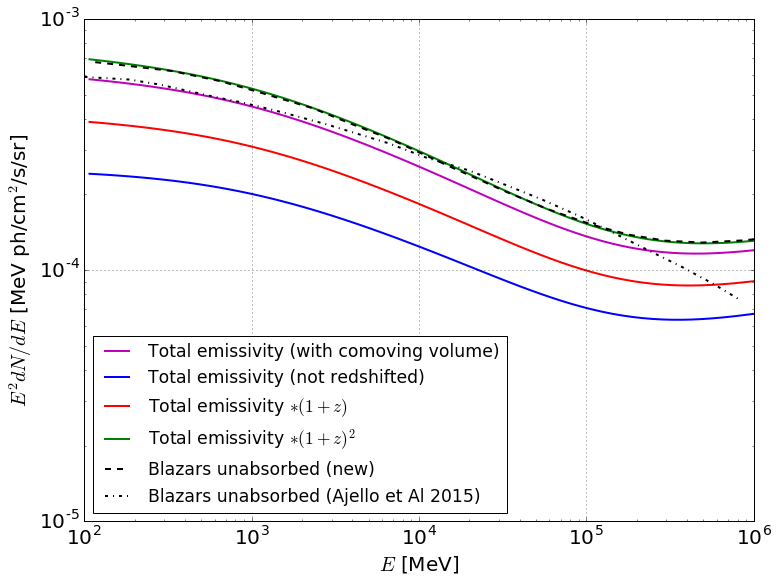

In [8]:
%matplotlib inline 
from matplotlib.pyplot import figure, show, legend, gca
from matplotlib import rcParams
label_size = 20
rcParams['xtick.labelsize'] = label_size
rcParams['ytick.labelsize'] = label_size
ax0 = figure(figsize=(12,9)).add_subplot(111)

ax0.plot(Eaj,Eaj**2*(Emiss*Vol).sum(axis=1),linewidth=2,linestyle="-",color='m',label="Total emissivity (with comoving volume)")   
ax0.plot(Eaj,Eaj**2*(Emiss*dVol).sum(axis=1),linewidth=2,linestyle="-",color='b',label="Total emissivity (not redshifted)")   
ax0.plot(Eaj,Eaj**2*(Emiss*dVolz).sum(axis=1),linewidth=2,linestyle="-",color='r',label="Total emissivity $*(1+z)$") 
ax0.plot(Eaj,Eaj**2*(Emiss*dVolz2).sum(axis=1),linewidth=2,linestyle="-",color='g',label="Total emissivity $*(1+z)^2$")

E_aj, E2dNdE_aj = loadtxt("Ajello2015-new.csv",delimiter=',',unpack=True)   
ax0.plot(E_aj,E2dNdE_aj,linewidth=2,linestyle="--",color='k',label="Blazars unabsorbed (new)")

E_aj, E2dNdE_aj = loadtxt("Ajello2015-fig3.csv",delimiter=',',unpack=True)   
ax0.plot(E_aj*1e3,E2dNdE_aj*1e3,linewidth=2,linestyle="-.",color='k',label="Blazars unabsorbed (Ajello et Al 2015)")

ax0.legend(loc='best',fontsize="xx-large")
ax0.set_xlabel("$E$ [MeV]",fontsize=label_size)
ax0.set_ylabel("$E^2 dN/dE$ [MeV ph/cm$^2$/s/sr]",fontsize=label_size)
ax0.set_xlim([1e2,1e6])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.grid(b=True,which='major')

show()